In [1]:
# Used this version of get_plasmid_inserts.py:
# !pip install git+https://github.com/nmateyko/labutils.git@5591e4ffd4a80c80687e5fe42b46392bd557d7e1

In [1]:
import Levenshtein
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
from Bio.Align import PairwiseAligner
from collections import Counter
from sequence_analysis.utils import read_fastq, revcomp
from sequence_analysis.get_plasmid_inserts import get_insert, first_index_of_kmer
from tqdm import tqdm
from rapidfuzz import fuzz, process

Get plasmid reads from fastq

In [3]:
with open('Lab_w7p_1_MORF_Stable.fastq', 'r') as f:
    fastq_reader = read_fastq(f)
    reads = [read for read in fastq_reader]
print(f"{len(reads)} reads.")

1902 reads.


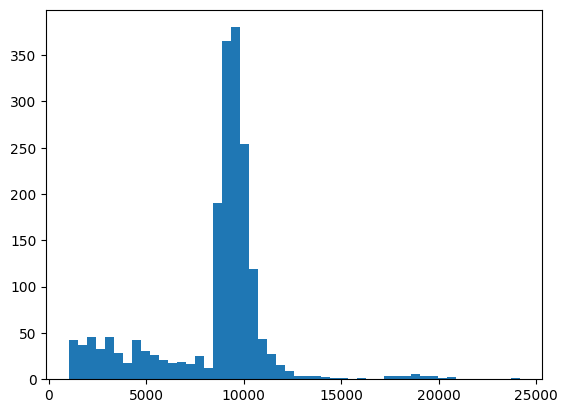

In [4]:
plt.hist([len(read[1]) for read in reads], bins=50)
plt.show()

See how many reads align properly to the expected vector sequence (https://benchling.com/s/seq-bPXmkxUwNKpX1cH3L3Ot?m=slm-LDQriBDlF3302DPZLMDe). Reindex the reads starting at the ampicillin resistance gene, as all plasmids should have this.

In [35]:
def extract_kmers(seq, k):
    kmers = []

    for i in range(len(seq) - k + 1):
        kmer = seq[i:i + k]
        kmers.append(kmer)

    return kmers

def find_best_match(seq, query):
    kmers = extract_kmers(seq, len(query))
    best_match, score, index = process.extractOne(query, kmers)
    return (best_match, score, index)

def reindex(read, query, threshold=85):
    header, seq, qual = read
    match, score, index = find_best_match(seq, query)
    rc_match, rc_score, rc_index = find_best_match(revcomp(seq), query)
    if score < threshold and rc_score < threshold:
        reindexed = None
    elif score > rc_score:
        reindexed_seq = seq[index:] + seq[:index]
        reindexed_qual = qual[index:] + qual[:index]
        reindexed = (header, reindexed_seq, reindexed_qual)
    else:
        reindexed_seq = revcomp(seq)[rc_index:] + revcomp(seq)[:rc_index]
        reindexed_qual = qual[::-1][rc_index:] + qual[::-1][:rc_index]
        reindexed = (header, reindexed_seq, reindexed_qual)
    return reindexed

In [46]:
ampr_start = "ATGAGTATTCAACATTTCCGTGTCGCCCTT"
sv40 = "AACTTGTTTATTGCAGCTTATAATGGTTAC"

# find AmpR start, then reindex
reindexed_reads = []
failed = []
for read in reads:
    reindexed = reindex(read, sv40)
    if reindexed is None:
        failed.append(read)
    else:
        reindexed_reads.append(reindexed)

In [47]:
print(f"{len(reindexed_reads)} reindexed reads.")

1562 reindexed reads.


In [48]:
with open("MORF_nogene_SV40_start.txt", 'rt') as f:
    plasmid = f.readline()
plasmid = plasmid.upper()

In [4]:
def encode_alignment(ref, query):
    encoded = []
    for i, j in zip(ref, query):
        if i == j:
            encoded.append(0)
        elif i != j and '-' not in {i, j}:
            encoded.append(1)
        elif i == '-' and j != '-':
            encoded.append(2)
        elif i != '-' and j == '-':
            encoded.append(3)
        else:
            raise ValueError("I wasn't expecting this")
    return encoded

def pad_lengths(d):
    max_len = max([len(v) for v in d.values()])
    for k, v in d.items():
        d[k] = v + [-1] * (max_len - len(v))

In [51]:
aligner = PairwiseAligner(mode='global', match_score=2, mismatch_score=-1,
                          open_gap_score=-5, extend_gap_score=0)

In [58]:
encoded_alignments = dict()
for read in tqdm(reindexed_reads):
    fwd_alignments = aligner.align(plasmid, read[1])
    rev_alignments = aligner.align(plasmid, revcomp(read[1]))
    fwd_alignment = next(fwd_alignments)
    rev_alignment = next(rev_alignments)
    best_alignment = fwd_alignment if fwd_alignment.score > rev_alignment.score else rev_alignment
    encoded = encode_alignment(best_alignment[0], best_alignment[1])
    encoded_alignments[read[0]] = encoded

100%|██████████| 1562/1562 [49:41<00:00,  1.91s/it]


In [60]:
# with open('encoded_alignments.pkl', 'wb') as f:
#     pickle.dump(encoded_alignments, f)

In [2]:
encoded_alignments = pickle.load(open('encoded_alignments.pkl', 'rb'))

In [5]:
pad_lengths(encoded_alignments)
alignments_df = pd.DataFrame.from_dict(encoded_alignments, orient='index')

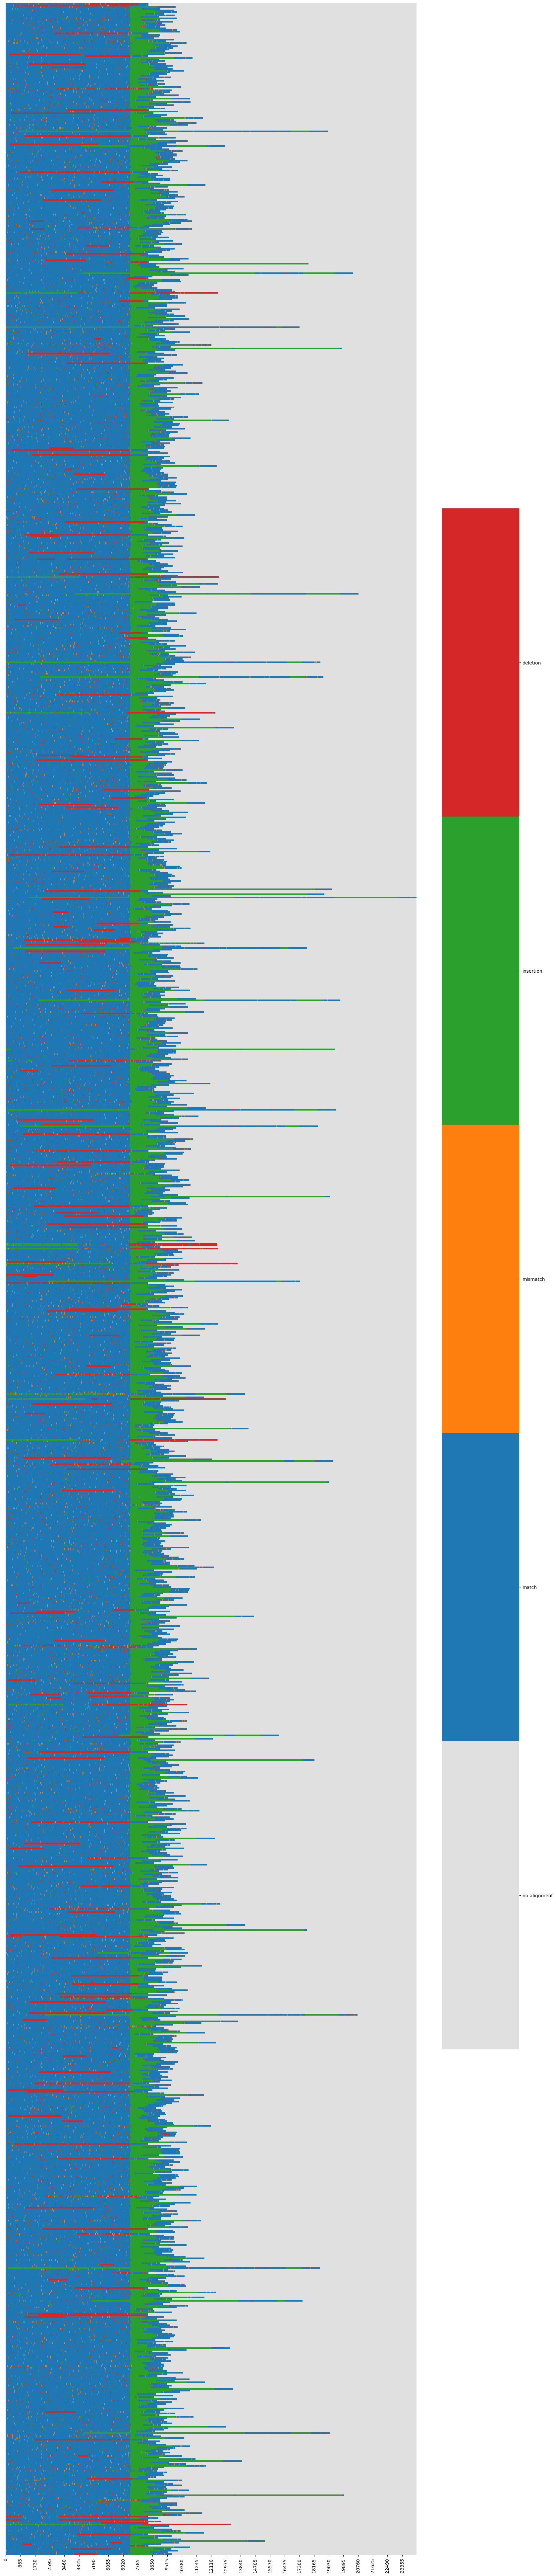

In [7]:
cmap = sns.color_palette(['#e0e0e0', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax = sns.heatmap(alignments_df, cmap=cmap)
plt.yticks([])
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / 5 * (0.5 + i) for i in range(5)])
colorbar.set_ticklabels(['no alignment', 'match', 'mismatch', 'insertion', 'deletion'])
plt.gcf().set_size_inches(20, 100)
ax.vlines([984], *ax.get_ylim())
plt.show()